# VQ-VAE


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import IPython.display as display

## Dataset

In [2]:
dataset = MNIST(
    root='../data',
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(24),
        v2.ToDtype(torch.float32, scale=True),
    ]),
)

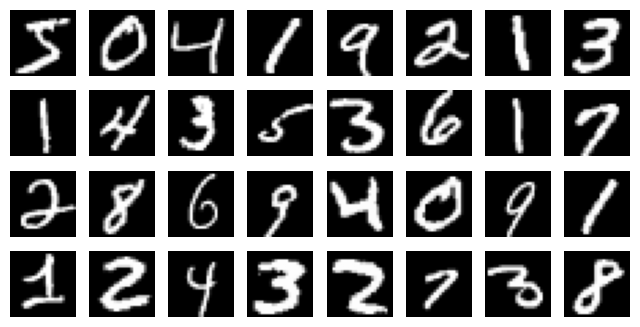

In [3]:
def plot_images(images, ncols=8):
    if isinstance(images, torch.Tensor):
        images = images.cpu().unbind(0)
    nrows = (len(images) - 1) // ncols + 1
    plt.figure(figsize=(ncols, nrows))
    for i, image in enumerate(images):
        if isinstance(image, torch.Tensor):
            image = v2.functional.to_pil_image(image)
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

plot_images([dataset[i][0] for i in range(32)])

## VQ-AVE Model

In [4]:
class VQCodebook(nn.Embedding):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        nn.init.uniform_(self.weight, -1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, ze: torch.Tensor):
        distances = torch.cdist(ze, self.weight)      # [N, Z, K]
        nearest_indices = torch.argmin(distances, -1) # [N, Z]
        e = super().forward(nearest_indices)          # [N, Z, D]
        # straight-through gradient trick
        zq = ze + (e - ze).detach()
        return zq, e, nearest_indices

    def find_with_indices(self, indices):
        return super().forward(indices)

In [5]:
class VQVAE(nn.Module):
    def __init__(self, latent_dim, num_embeddings):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),      # (N, 32, 12, 12)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),     # (N, 64, 6, 6)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),    # (N, 128, 3, 3)
            nn.ReLU(),
            nn.Conv2d(128, latent_dim, 1),  # (N, D, 3, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 1), # (N, 128, 3, 3)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (N, 64, 6, 6)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (N, 32, 12, 12)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),     # (N, 1, 24, 24)
        )
        self.codebook = VQCodebook(num_embeddings, latent_dim)

    def _from_image_latent(self, z):
        """(N, D, 3, 3) -> (N, 9, D)"""
        return z.flatten(2).transpose(1, 2)

    def _to_image_latent(self, z):
        """(N, 9, D) -> (N, D, 3, 3)"""
        return z.transpose(1, 2).unflatten(2, (3, 3))

    def forward(self, x):
        ze = self.encoder(x)
        zq, e, _ = self.codebook(self._from_image_latent(ze))
        logits = self.decoder(self._to_image_latent(zq))
        return logits, ze, self._to_image_latent(e)

    def encode(self, x):
        ze = self.encoder(x)
        _, _, indices = self.codebook(self._from_image_latent(ze))
        return indices.reshape(-1, 1, 3, 3)  # (N, 1, 3, 3)

    def decode(self, z):
        z = z.reshape(-1, 9)  # (N, 9)
        zq = self.codebook.find_with_indices(z)
        logits = self.decoder(self._to_image_latent(zq))
        return logits

## Training VQ-VAE

In [6]:
def plot_losses(values_dict):
    n = len(values_dict)
    display.clear_output(wait=True)
    plt.figure(figsize=(5 * n, 3))
    for i, (label, values) in enumerate(values_dict.items()):
        plt.subplot(1, n, i + 1)
        plt.plot(values)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel(label)
    plt.show()

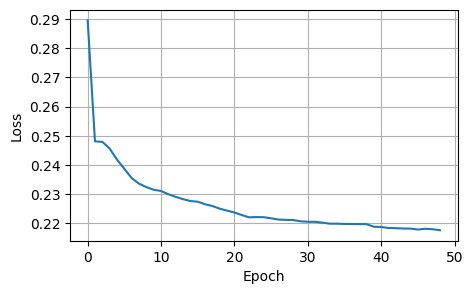

In [7]:
epochs = 50
batch_size = 128
learning_rate = 1e-3
latent_dim = 128
num_embeddings = 512

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda")
model = VQVAE(latent_dim, num_embeddings).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def criterion(logits, x, ze, e, beta=0.25):
    reconstruction = F.binary_cross_entropy_with_logits(logits, x)
    codebook = F.mse_loss(e, ze.detach())
    commitment = F.mse_loss(ze, e.detach())
    return reconstruction + codebook + beta * commitment

losses = []
for epoch in range(epochs):
    epoch_losses = []
    for x, _ in dataloader:
        x = x.to(device)

        logits, ze, e = model(x)
        loss = criterion(logits, x, ze, e)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(loss)
    if len(losses) > 1:
        plot_losses({"Loss": losses[1:]})  # skip the first epoch in plot

## PixelCNN to model autoregressive distribution over z

In [8]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, causal=False):
        super().__init__()
        # (N x N) vertical convolution
        self.register_buffer('v_mask', torch.zeros(kernel_size, kernel_size))
        self.v_mask[:kernel_size // 2, :] = 1
        self.v_conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        # (1 x N) horizontal convolution
        self.register_buffer('h_mask', torch.zeros(1, kernel_size))
        self.h_mask[:, :kernel_size // 2] = 1
        if not causal:
            self.h_mask[:, kernel_size // 2] = 1
        self.h_conv = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, kernel_size // 2))

    def forward(self, x):
        self.v_conv.weight.data *= self.v_mask
        v = self.v_conv(x)
        self.h_conv.weight.data *= self.h_mask
        h = self.h_conv(x)
        return v + h


class ResidualBock(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()
        self.net = nn.Sequential(
            MaskedConv2d(channels, channels, kernel_size),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.net(x)


class LatentPixelCNN(nn.Sequential):
    def __init__(self, model_dim, kernel_size, num_blocks, num_categories):
        super().__init__(
            MaskedConv2d(1, model_dim, kernel_size, causal=True),
            *[ResidualBock(model_dim, kernel_size) for _ in range(num_blocks)],
            nn.Conv2d(model_dim, num_categories, 1),
        )
        self.K = num_categories

    def forward(self, x):
        return super().forward(x / self.K)

### Training PixelCNN model

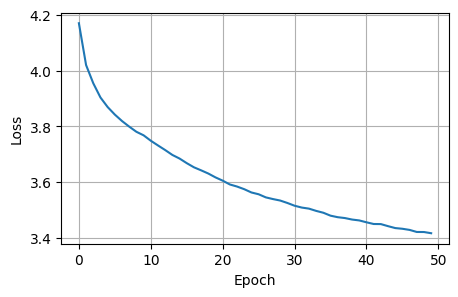

In [9]:
pixelcnn_epochs = 50
pixelcnn = LatentPixelCNN(64, 3, 10, num_embeddings).to(device)
pixelcnn_opt = Adam(pixelcnn.parameters(), lr=1e-3)

pixelcnn_losses = []
pixelcnn.train()
for i in range(pixelcnn_epochs):
    epoch_losses = []
    for x, _ in dataloader:
        x = x.to(device)

        with torch.no_grad():
            z = model.encode(x)

        logits = pixelcnn(z.to(torch.float32))
        loss = F.cross_entropy(logits, z.squeeze(1))

        pixelcnn_opt.zero_grad()
        loss.backward()
        pixelcnn_opt.step()

        epoch_losses.append(loss.item())

    pixelcnn_losses.append(sum(epoch_losses) / len(epoch_losses))
    plot_losses({"Loss": pixelcnn_losses})


## Sampling

In [10]:
def sample(model, n):
    device = next(model.parameters()).device
    pixelcnn.eval()
    model.eval()
    with torch.inference_mode():
        # Sample latent z with PixelCNN
        z = torch.zeros(n, 1, 3, 3, device=device)
        for i in range(3):
            for j in range(3):
                logits = pixelcnn(z)[:, :, i, j]
                dist = torch.distributions.Categorical(logits=logits)
                z[:, 0, i, j] = dist.sample()

        # Generate image from z
        logits = model.decode(z.to(torch.long))
        return logits.sigmoid()

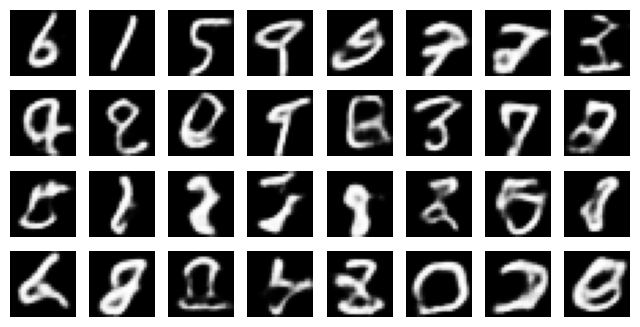

In [11]:
images = sample(model, 32)
plot_images(images)